# Control policy optimization

In this example, a symbolic policy is evolved for the pendulum swingup task. Gymnax is used for simulation of the pendulum environment, showing that Kozax can easily be extended to external libraries.

In [1]:
# Specify the cores to use for XLA
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10'
import jax
import jax.numpy as jnp
import jax.random as jr
import gymnax
import matplotlib.pyplot as plt

from kozax.genetic_programming import GeneticProgramming
from kozax.fitness_functions.Gymnax_fitness_function import GymFitnessFunction

These device(s) are detected:  [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


Kozax provides a simple fitness function for Gymnax environments, which is used in this example.

In [2]:
#Define hyperparameters
population_size = 100
num_populations = 5
num_generations = 50
batch_size = 16

fitness_function = GymFitnessFunction("Pendulum-v1")

#Define operators and variables
operator_list = [
    ("+", lambda x, y: jnp.add(x, y), 2, 0.5), 
    ("-", lambda x, y: jnp.subtract(x, y), 2, 0.1), 
    ("*", lambda x, y: jnp.multiply(x, y), 2, 0.5), 
    ]

variable_list = [[f"y{i}" for i in range(fitness_function.env.observation_space(fitness_function.env_params).shape[0])]]

#Initialize strategy
strategy = GeneticProgramming(num_generations, population_size, fitness_function, operator_list, variable_list, num_populations=num_populations)

Input data should be formatted as: ['y0', 'y1', 'y2'].


In [3]:
key = jr.PRNGKey(0)
data_key, gp_key = jr.split(key, 2)

# The data comprises keys need to initialize the batch of environments.
batch_keys = jr.split(data_key, batch_size)

strategy.fit(gp_key, batch_keys, verbose=1)

Compiling code for evaluation and evolution...
Finished compilation in 8.35 seconds
In generation 1
Complexity: 1, fitness: 1322.7767333984375, equation: -0.000985
Complexity: 3, fitness: 1240.409912109375, equation: 3.42*y0
Complexity: 5, fitness: 825.0570678710938, equation: y0*(-y2 - 0.402)
Complexity: 7, fitness: 666.5424194335938, equation: -0.822*y0*y2 + y1
Complexity: 9, fitness: 642.9760131835938, equation: -1.1*y0*y2*(y0 + 1.59)
In generation 2
Complexity: 1, fitness: 1284.7818603515625, equation: y0
Complexity: 3, fitness: 1233.585205078125, equation: -2.29*y1
Complexity: 5, fitness: 821.8189697265625, equation: -0.943*y0*y2
Complexity: 7, fitness: 666.5424194335938, equation: -0.822*y0*y2 + y1
Complexity: 9, fitness: 642.9760131835938, equation: -1.1*y0*y2*(y0 + 1.59)
In generation 3
Complexity: 1, fitness: 1284.7818603515625, equation: y0
Complexity: 3, fitness: 1233.585205078125, equation: -2.29*y1
Complexity: 5, fitness: 730.1170043945312, equation: -1.56*y0*y2
Complexity

## Visualize best solution

We can visualize the sin and cos position in a trajectory using the best solution.

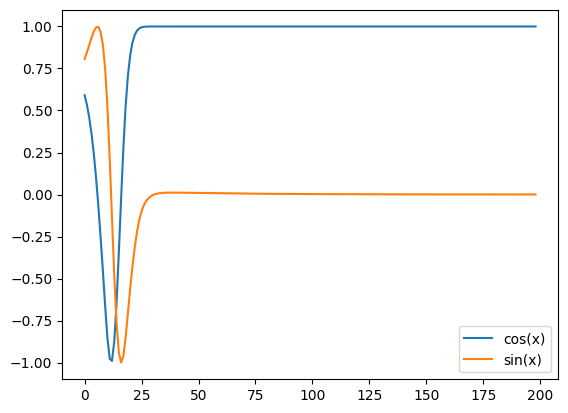

In [ ]:
env, env_params = gymnax.make('Pendulum-v1')
key = jr.PRNGKey(2)
obs, env_state = env.reset(key)
all_obs = []
treward = []
actions = []

done = False

sin = jnp.sin
cos = jnp.cos

T=199
for t in range(T):

    y0, y1, y2 = obs
    action = -1.67*y0*y1 - 2.18*y0*y2 - 4.37*y1
    obs, env_state, reward, done, _ = env.step(
                jr.fold_in(key, t), env_state, action, env_params
            )
    
    all_obs.append(obs)
    treward.append(reward)
    actions.append(action)

all_obs = jnp.array(all_obs)
plt.plot(all_obs[:,0], label='cos(x)')
plt.plot(all_obs[:,1], label='sin(x)')
plt.legend()